In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import auc, roc_curve, roc_auc_score,  classification_report, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix
from helper_functions import *
from pipeline import *

In [2]:
X = pipeline('../data/stratified_train.csv', drop_cat=False)
y = X.pop('Target')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

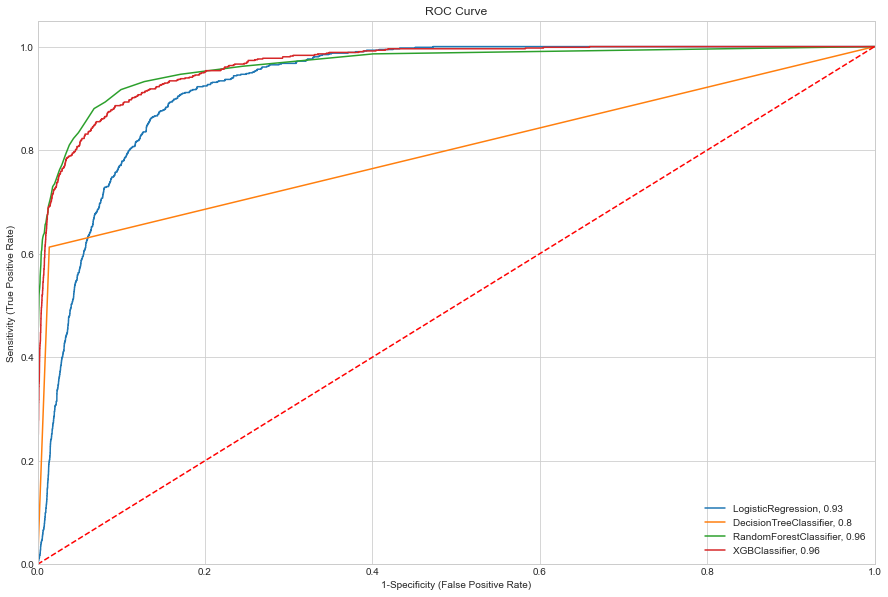

<Figure size 432x288 with 0 Axes>

In [6]:
classification_models = [LogisticRegression(class_weight='balanced', max_iter=10000, n_jobs=-1), DecisionTreeClassifier(), RandomForestClassifier(class_weight='balanced'), XGBClassifier()]
model_comparison(classification_models, X_train, y_train, X_test, y_test);

Accuracy is not a valid evaluation metric because of the class imbalance.

Which is worse: **FP** or **FN**?

*Reason shows a **FN** (like ignoring a fire alarm) is MUCH WORSE.*

$$Recall = \frac{TP}{TP + FN}$$

Therefore **Recall** is the best metric to evaluate the models by. Therefore out-of-box Random Forest outperforms XGB.

In [16]:
rf = RandomForestClassifier(class_weight='balanced')
rf_train_scores = cross_val_score(rf, X_train, y_train,
                           scoring='recall', cv=30, n_jobs=-1)
print('RF OOB Training Recall', round(np.mean(rf_train_scores),4))

rf_test_scores = cross_val_score(rf, X_test, y_test,
                           scoring='recall', cv=30, n_jobs=-1)
print('RF OOB Validation Recall', round(np.mean(rf_test_scores),4))

RF OOB Training Recall 0.4046


/Users/chelseazaloumis/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RF OOB Validation Recall 0.1697


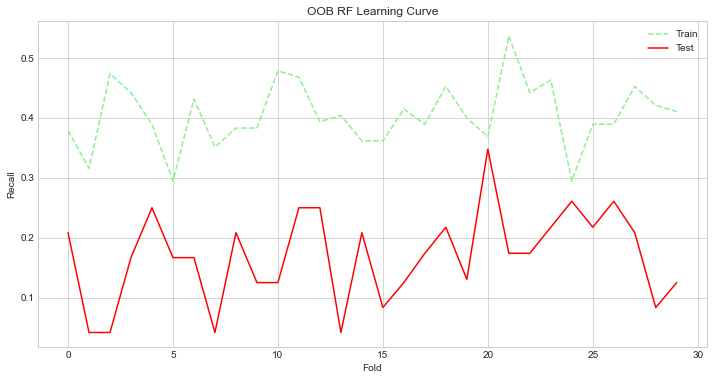

In [27]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(range(0, len(rf_train_scores)), rf_train_scores, linestyle='--', c='lightgreen', label='Train')
ax.plot(range(0, len(rf_test_scores)), rf_test_scores, c='red', label='Test')
ax.set_title('OOB RF Learning Curve')
ax.set_xlabel('Fold')
ax.set_ylabel('Recall')
ax.legend();

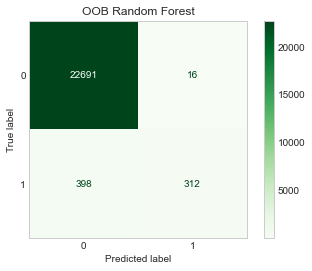

In [18]:
rf.fit(X_train, y_train)
plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Greens)
plt.title('OOB Random Forest')
plt.grid(False);

In [19]:
xgb = XGBClassifier()
xgb_train_scores = cross_val_score(xgb, X_train, y_train,
                           scoring='recall', cv=30, n_jobs=-1)
print('XGB OOB Training Recall', round(np.mean(xgb_train_scores),4))

xgb_test_scores = cross_val_score(xgb, X_test, y_test,
                           scoring='recall', cv=30, n_jobs=-1)
print('XGB OOB Validation Recall', round(np.mean(xgb_test_scores),4))

/Users/chelseazaloumis/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGB OOB Training Recall 0.3842
XGB OOB Validation Recall 0.2597


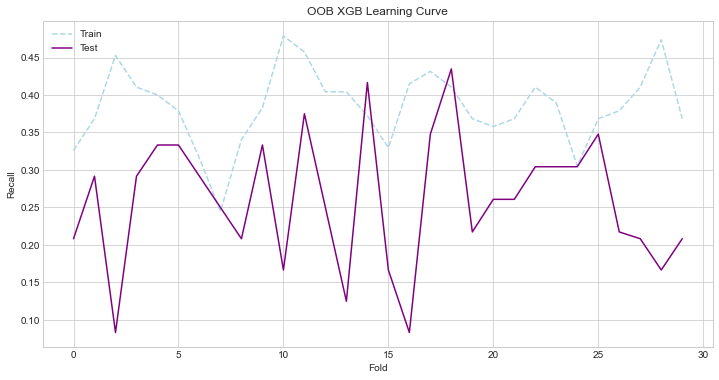

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(range(0, len(xgb_train_scores)), xgb_train_scores, linestyle='--', c='lightblue', label='Train')
ax.plot(range(0, len(xgb_test_scores)), xgb_test_scores, c='purple', label='Test')
ax.set_title('OOB XGB Learning Curve')
ax.set_xlabel('Fold')
ax.set_ylabel('Recall')
ax.legend();

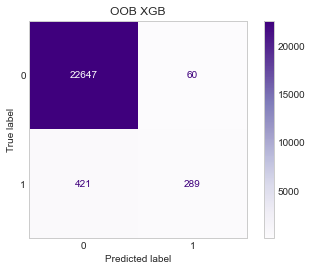

In [23]:
xgb.fit(X_train, y_train)
plot_confusion_matrix(xgb, X_test, y_test, cmap=plt.cm.Purples)
plt.title('OOB XGB')
plt.grid(False);

*Both RF and XGB are underfitting. XGB outperforms RF OOB very slightly with cross validation. Next step: GridSearchCV or RandomizedSearchCV*

## GridSearchCV
---

In [29]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [31]:
# Tune RF
rf_parameter_grid = {
    'max_depth': [10, 30, 50, 70],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [2, 5],
    'n_estimators': [200, 400, 500, 600]
}

In [ ]:
rf_params, rf_gridsearch = gridsearch_with_output(RandomForestClassifier(class_weight='balanced'), 
                                                  rf_parameter_grid, X_train, y_train)

filename = 'tuned-rf.pkl'
pickle.dump(rf_gridsearch, open(filename, 'wb'))

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min


In [30]:
xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [ ]:
# Tune XGBoost
xgb_parameter_grid = {
                    'max_depth': [6, 9],
                    'n_estimators': [200, 400, 500, 600], 
                    'learning_rate': [0.01, 0.1],
                    'lambda': [0.5, 0.8], # l2 regualrization
                    'alpha': [0.25, 0.5]  # l1 regularization
                    }

In [ ]:
xgb_params, xgb_gridsearch = gridsearch_with_output(XGBClassifier(), 
                                                    xgb_parameter_grid, X_train, y_train)

filename = 'tuned-xgb.pkl'
pickle.dump(xgb_gridsearch, open(filename, 'wb'))

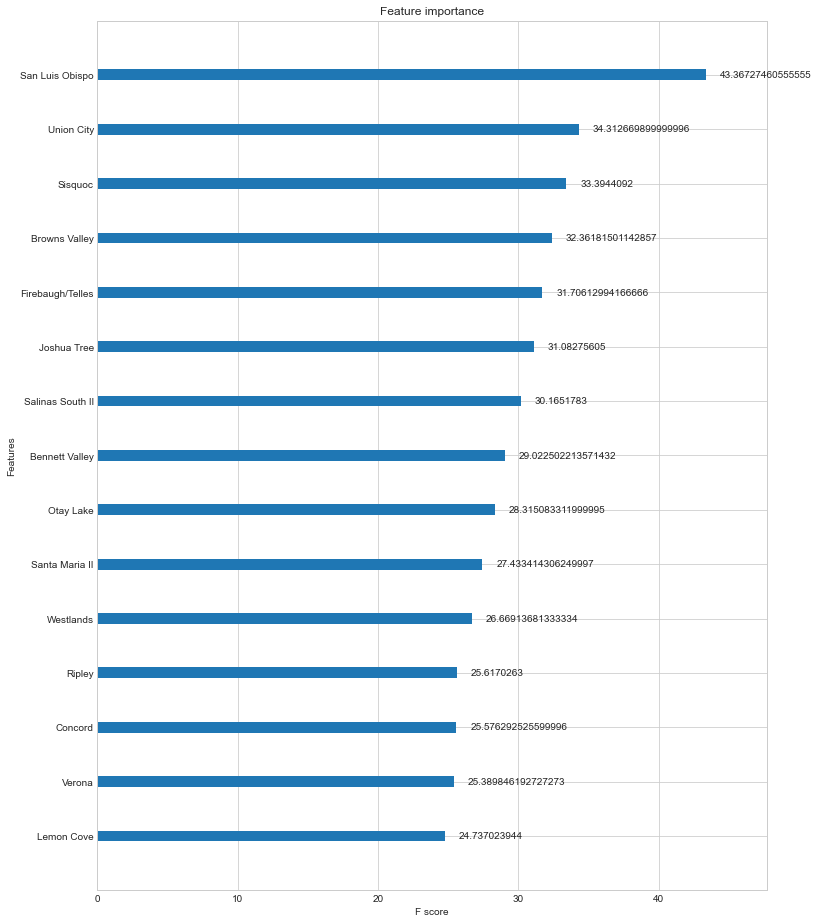

In [26]:
fig, ax = plt.subplots(figsize=(12,16))
plot_importance(xgb, ax=ax, max_num_features=15, importance_type='gain');

XGB's top 15 features to split on for maximum average gain. To better understand the tabular dataset, creating another data pipeline that removes the `Stn Id` column before one-hot encoding all stations.

In [2]:
X = pipeline('../data/stratified_train.csv')
y = X.pop('Target')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [3]:
xgb = XGBClassifier()
xgb_recall_scores = cross_val_score(xgb, X_train, y_train,
                           scoring='recall', cv=5, n_jobs=-1)
print('XGB OOB Recall', np.mean(xgb_recall_scores))

xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)
print('Out of box XGB:')
print(classification_report(y_test, xgb_y_pred))

XGB OOB Recall 0.13450704225352114
Out of box XGB:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     22707
           1       0.78      0.17      0.29       710

    accuracy                           0.97     23417
   macro avg       0.87      0.59      0.64     23417
weighted avg       0.97      0.97      0.97     23417



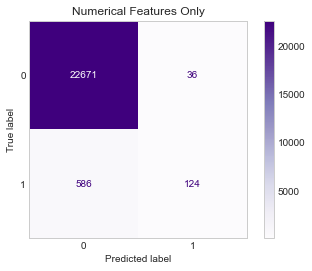

In [21]:
plot_confusion_matrix(xgb, X_test, y_test, cmap=plt.cm.Purples)
plt.title('Numerical Features Only')
plt.grid(False);

In [5]:
recall_score(y_test, xgb_y_pred)

0.17464788732394365

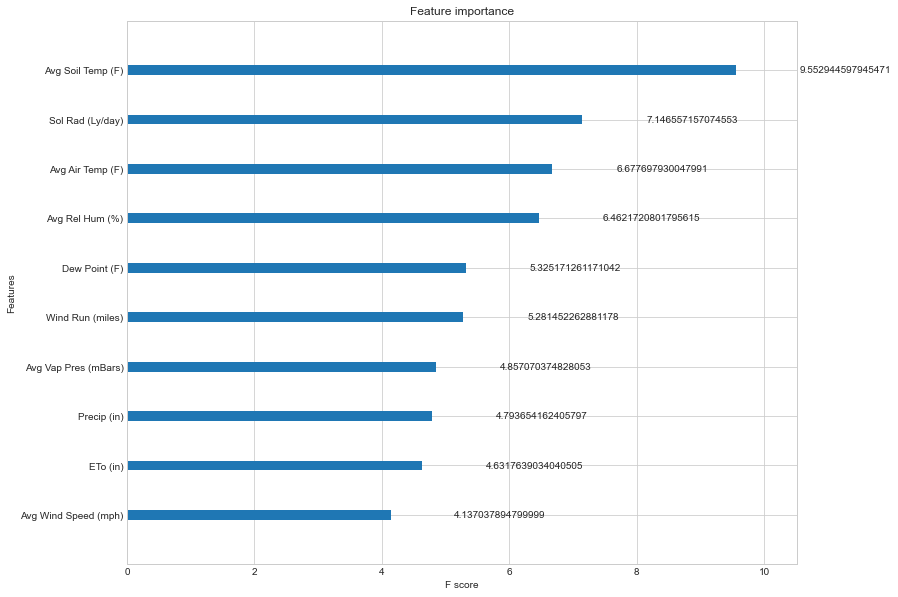

In [10]:
fig, ax = plt.subplots(figsize=(12,10))
plot_importance(xgb, ax=ax, importance_type='gain');

*XGB performs MUCH MUCH MUCH worse with only numerical features.*

In [16]:
exp_X_train = pd.DataFrame(X_train['Avg Soil Temp (F)']).copy()
exp_X_test = pd.DataFrame(X_test['Avg Soil Temp (F)']).copy()
clf = LogisticRegression()
clf.fit(exp_X_train, y_train)
clf_y_pred = clf.predict(exp_X_test)
recall_score(y_test, clf_y_pred)

0.0

In [17]:
clf.coef_

array([[0.8670423]])